# Deter Model training



In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
!pwd

/mnt1/haridas/projects/AdaptiveCards/source/pic2card/notebooks


In [14]:
import os
import sys
from pathlib import Path, PurePath
import matplotlib.pyplot as plt
import glob


sys.path.insert(0, "/home/haridas/projects/opensource/detr")
sys.path.insert(0, "../")
os.environ["CUDA_VISIBLE_DEVICES"] = ""

%matplotlib inline

In [193]:
import pandas as pd
import numpy as np

import seaborn as sns
from mystique.utils import plot_results

In [4]:

import torch
from torch.utils.data import DataLoader, SequentialSampler
import torchvision.transforms as T
import torchvision.transforms.functional as F
from PIL import Image

import datasets
from datasets import build_dataset, get_coco_api_from_dataset
from datasets.coco_eval import CocoEvaluator
from datasets.coco import make_coco_transforms

from models.detr import DETR, SetCriterion, PostProcess
from models.transformer import build_transformer
from models.backbone import build_backbone
from models.matcher import build_matcher
from engine import evaluate

from util.misc import collate_fn, NestedTensor
from util.plot_utils import plot_logs, plot_precision_recall

from datasets.coco import make_coco_transforms

In [5]:
# img_transform = make_coco_transforms("val")
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [423]:
T.Resize(800)

Resize(size=800, interpolation=PIL.Image.BILINEAR)

## Strip Trained model for transfer learning

In [6]:
# checkpoint = torch.load(f"{basedir}/detr-r50-e632da11.pth", map_location='cpu')
# checkpoint = torch.load(f"{basedir}/detr-r101-dc5-a2e86def.pth", map_location='cpu')

In [7]:
# checkpoint["model"].keys()

In [8]:
# # Param sets that needs to be custom learned.
# del checkpoint["model"]["class_embed.weight"]
# del checkpoint["model"]["class_embed.bias"]
# del checkpoint["model"]["query_embed.weight"]

In [9]:
# torch.save(checkpoint, f"{basedir}/detr-r101-dc5-a2e86def-class-head.pth")

## Dataset 

In [281]:
class Args:
    coco_path = "/home/haridas/projects/mystique/data/train_and_test-2020-Jun-05-coco/"
    dataset_file = "pic2card"
    masks = False
    
train_ds = datasets.custom_coco_build("train", Args)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [298]:
image, target = super(datasets.coco.CocoDetection, train_ds).__getitem__(10)
target = {'image_id': train_ds.ids[0], 'annotations': target}
image, target = train_ds.prepare(image, target)

In [408]:
target

{'boxes': tensor([[240.,  32., 305.,  55.],
         [245.,  54., 296.,  77.],
         [223.,  89., 325., 130.],
         [ 32., 142., 122., 167.],
         [430., 142., 497., 167.],
         [ 26.,  28., 131., 135.],
         [411.,  27., 516., 134.]]),
 'labels': tensor([1, 1, 1, 1, 1, 5, 5]),
 'image_id': tensor([1]),
 'area': tensor([ 1495,  1173,  4182,  2250,  1675, 11235, 11235]),
 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0]),
 'orig_size': tensor([196, 540]),
 'size': tensor([196, 540])}

In [370]:
_image, _target = datasets.transforms.RandomResize([800], max_size=1333)(image, target)
_target

{'boxes': tensor([[ 592.4445,   79.0204,  752.8981,  135.8163],
         [ 604.7870,  133.3469,  730.6815,  190.1429],
         [ 550.4796,  219.7755,  802.2685,  321.0204],
         [  78.9926,  350.6531,  301.1593,  412.3878],
         [1061.4630,  350.6531, 1226.8536,  412.3878],
         [  64.1815,   69.1429,  323.3759,  333.3673],
         [1014.5611,   66.6735, 1273.7555,  330.8979]]),
 'labels': tensor([1, 1, 1, 1, 1, 5, 5]),
 'image_id': tensor([1]),
 'area': tensor([ 9113.1152,  7150.2905, 25492.3398, 13715.3906, 10210.3467, 68485.5156,
         68485.5156]),
 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0]),
 'orig_size': tensor([196, 540]),
 'size': tensor([ 484, 1333])}

In [279]:
# torch.rand()
# region = T.RandomCrop.get_params(image, (799, 1000))

In [362]:
# F.crop(image, *T.RandomCrop.get_params(image, (400, 300)))
# image.shape

In [363]:
# datasets.transforms.crop(image, target, )

In [364]:
# datasets.transforms.crop

In [257]:
# np.asarray(img)

In [259]:
# image.permute(1, 2, 0).numpy()
# image.permute(1, 2, 0).numpy()

In [228]:
# Image.fromarray(image)

In [11]:
# The index are directly from the coco dataset index.
CLASSES = {
     0: 'background', # This one is a default class learned by model, or a catch all.
     1: 'textbox',
     2: 'radiobutton',
     3: 'checkbox',
     4: 'actionset',
     5: 'image',
     6: 'rating'
}

## Generate Coco Metrics

In [38]:
class DefaultConf:
    # Basic network
    backbone = "resnet50"
    position_embedding = "sine"
    hidden_dim = 256
    dropout = 0.1
    nheads = 8
    dim_feedforward = 2048
    enc_layers = 6
    dec_layers = 6
    pre_norm = False
    num_queries = 100
    aux_loss = False
    
    # Force to eval model
    lr_backbone = 0
    masks = False
    dilation = False
    device = "cuda"
    
    # Loss tuning params.
    set_cost_class = 1
    set_cost_bbox = 5
    set_cost_giou = 2
    bbox_loss_coef = 5
    giou_loss_coef = 2
    eos_coef = 0.1
    losses = ["labels", "boxes", "cardinality"]

    # Configuration fitting the pic2card specific
    # class configuration.
    coco_path = "/home/haridas/projects/mystique/data/train_and_test-2020-Jun-05-coco/"
    dataset_file = "pic2card"

weight_dict = {
    'loss_ce': 1,
    'loss_bbox': DefaultConf.bbox_loss_coef,
    'loss_giou': DefaultConf.giou_loss_coef
}
    
backbone = build_backbone(DefaultConf)

transformer_network = build_transformer(DefaultConf)
matcher = build_matcher(DefaultConf)
criterion = SetCriterion(num_classes=len(CLASSES),
                         matcher=matcher,
                         weight_dict=weight_dict,
                         eos_coef=DefaultConf.eos_coef,
                         losses=DefaultConf.losses
                        )
postprocessors = {"bbox": PostProcess()}

dataset_test = build_dataset(image_set="test", args=DefaultConf)
sample_test = SequentialSampler(dataset_test)
base_ds = get_coco_api_from_dataset(dataset_test)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [7]:

basedir = Path("/home/haridas/projects/opensource/detr/")
model_path = basedir / "outputs-2020-06-30-1593500748" / "checkpoint.pth"
state_dict = torch.load(model_path, map_location="cpu")

detr = DETR(backbone=backbone,
            transformer=transformer_network,
            num_queries=100, num_classes=6, aux_loss=False)
detr.load_state_dict(state_dict["model"])
detr.eval();

In [8]:
data_loader_test = DataLoader(dataset_test,
                              batch_size=2,
                              sampler=sample_test,
                              drop_last=False,
                              collate_fn=collate_fn,
                              num_workers=1)

In [21]:
# for samples, targets in data_loader_test:
#     print([i['image_id'] for i in targets])
#     import pdb; pdb.set_trace()

In [124]:
# test_stats, coco_evaluator = evaluate(
#     detr, criterion, postprocessors,
#     data_loader_test,
#     base_ds,
#     device="cpu",
#     output_dir="./out")

# Model Inference

In [194]:
def load_detr_model(model_path, num_queries=60, num_classes=6):
    basedir = Path(model_path)
    model_path = basedir / "checkpoint.pth"
    state_dict = torch.load(model_path, map_location="cpu")
    detr = DETR(backbone=backbone,
                transformer=transformer_network,
                num_queries=num_queries,
                num_classes=num_classes, aux_loss=False)
    detr.load_state_dict(state_dict["model"])
    detr.eval();
    return detr

## Single image Inference

In [39]:
detr = load_detr_model("/home/haridas/projects/opensource/detr/best_model")

In [418]:
transform_test = make_coco_transforms("test")

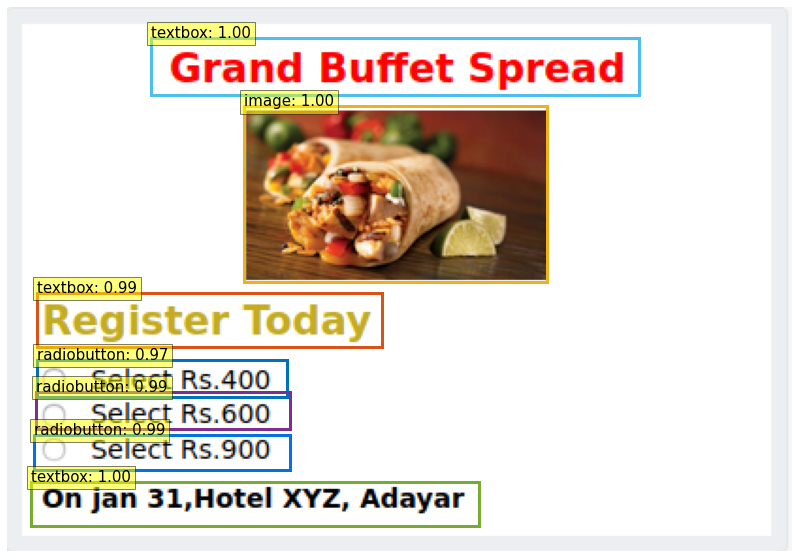

In [205]:
# output['pred_boxes'][-1, keep]
img = Image.open("/home/haridas/projects/AdaptiveCards-ro/source/pic2card/app/assets/samples/3.png").convert("RGB")
img = Image.open("/home/haridas/projects/mystique/data/templates_test_data/1.png").convert("RGB")
probs, boxes = detect(img, detr_trace_module, transform, threshold=0.8)
scores = probs.max(-1).values.detach().numpy()
classes = probs.max(-1).indices.detach().numpy()
plot_results(img, classes, scores, boxes, label_map=CLASSES, score_threshold=0.8)

In [198]:
scores.max(-1).values.detach().numpy()

array([0.92813474, 0.9515143 , 0.85023963, 0.9684327 , 0.8211578 ,
       0.9917258 , 0.93736345, 0.99552417], dtype=float32)

## Using libraries

In [25]:
from mystique.models.pth.detr.predict import detect as detect_

In [21]:
img.size

(417, 289)

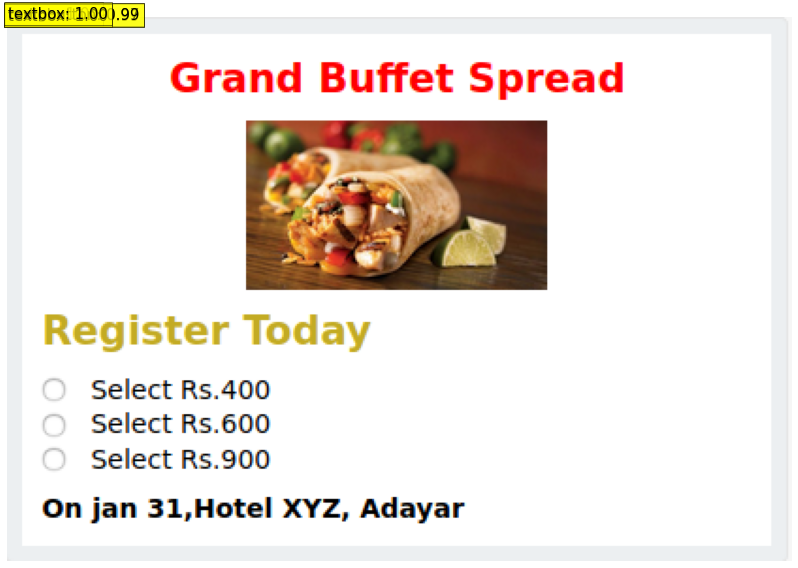

In [27]:
scores_, boxes_ = detect_(img, detr_trace_module, transform_, threshold=0.8)
plot_results(img, scores_, boxes_, label_map=CLASSES)

In [31]:
boxes_

tensor([[0.0329, 0.7852, 0.3596, 0.8505],
        [0.0368, 0.6468, 0.3558, 0.7153],
        [0.0367, 0.5248, 0.4761, 0.6235],
        [0.3009, 0.1809, 0.6868, 0.5036],
        [0.0361, 0.7059, 0.3597, 0.7746],
        [0.0292, 0.8717, 0.6001, 0.9522],
        [0.1819, 0.0547, 0.8046, 0.1601]], grad_fn=<StackBackward>)

## Ploting train vs eval performance

In [62]:
detr_experiments = [Path(i) for i in glob.glob("/home/haridas/projects/opensource/detr/outputs-2020-07-07*")]

In [18]:
p = Path("/home/haridas/projects/opensource/detr/best_model/")

In [80]:
log_df = pd.read_json(p / "log.txt", lines=True)

In [94]:
# log_df.head().test_coco_eval_bbox[0]

In [99]:
state_dict = torch.load(p / "checkpoint.pth", map_location="cpu")

In [119]:
torch.save(state_dict["model"], p / "checkpoint_model.pth")

In [120]:
# state_dict["model"]

In [21]:
score = torch.load(p / 'eval.pth')

In [31]:
score.keys()

dict_keys(['params', 'counts', 'date', 'precision', 'recall', 'scores'])

iter latest: mAP@50= 30.1, score=0.292, f1=0.309
iter 000: mAP@50=-32.5, score=-0.297, f1=-0.297
iter 050: mAP@50=-03.3, score=0.001, f1=-0.115
iter 100: mAP@50= 26.4, score=0.237, f1=0.284
iter 150: mAP@50= 28.2, score=0.268, f1=0.298
iter 200: mAP@50= 29.3, score=0.282, f1=0.304
iter 250: mAP@50= 27.7, score=0.275, f1=0.295


(<Figure size 1152x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb3d3164c18>,
       dtype=object))

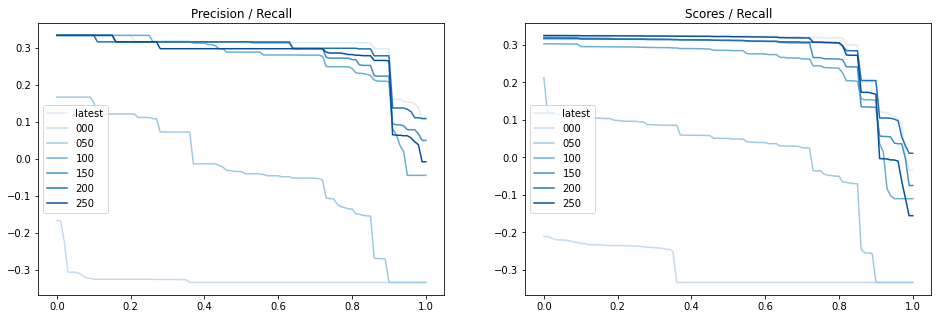

In [121]:
# glob.glob(p / 'eval/*')
plot_precision_recall(
    [Path(p) for p in glob.glob("/home/haridas/projects/opensource/detr/best_model/eval/*.pth")]
     )

In [65]:
detr_experiments.sort()

plot_utils.py::plot_logs info: logs param expects a list argument, converted to list[Path].


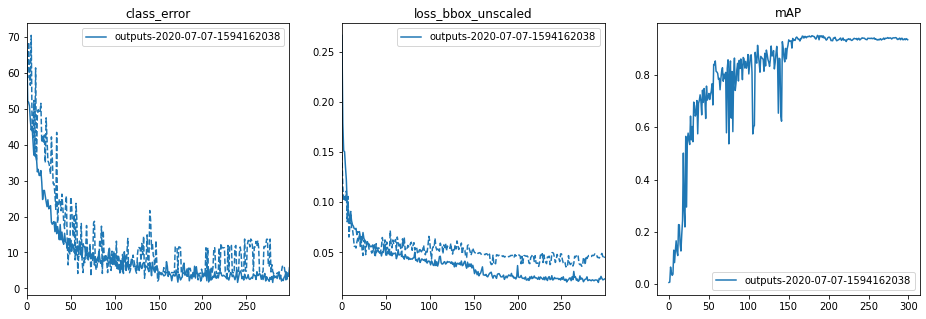

In [73]:
plot_logs(detr_experiments[-1])

# TorchScript 

See how the model can be serialized efficiently for production purpose.

In [31]:
img = Image.open("/home/haridas/projects/AdaptiveCards-ro/source/pic2card/app/assets/samples/5.png").convert("RGB")
# im = transform(img).unsqueeze(0)

In [20]:
img_np = np.asarray(img)
im = transform(img).unsqueeze(0)

### Torch Jit Trace

In [42]:
detr_trace_module = torch.jit.trace(detr, im, strict=False)

In [52]:
detr_trace_module.save("/home/haridas/projects/pic2card-models/pytorch/detr_trace.pt")

In [7]:
detr_trace_module = torch.jit.load("/home/haridas/projects/pic2card-models/pytorch/detr_trace.pt")

In [56]:
t = detr_trace_module(im)

In [150]:
# print(detr_trace_module.graph)

In [36]:
from typing import List

@torch.jit.script
def an_error(x):
    #r = torch.rand(1)
    return x

@torch.jit.script
def foo(x, y):
    if x.max() > y.max():
        r = x
    else:
        r = y
    return r

In [34]:
# print(type(foo))
# print(torch.jit.trace(foo, (torch.ones(2,3), torch.ones(1,2))).code)
# print(foo.code)

In [38]:
# torch.jit.trace(foo, (torch.ones(2,3), torch.ones(1,2)))

In [33]:
# print(foo.graph)

### Torch Jit Script

In [19]:
detr_tscript = torch.jit.script(detr)

In [50]:
# print(detr_tscript.code)

In [31]:
detr_tscript.save("/home/haridas/projects/pic2card-models/pytorch/detr.pt")

In [32]:
# print(detr_tscript.code)

In [383]:
# !du -sh /home/haridas/projects/pic2card-models/pytorch/detr.pt

torch.Size([1, 3, 800, 1355])

In [380]:
detr_tscript = torch.jit.load("/home/haridas/projects/pic2card-models/pytorch/detr.pt")

In [389]:
# nested_tensor = NestedTensor(im, None)
# detr_tscript(img)

In [151]:
# detr_tscript(nested_tensor)
# print(detr_tscript.graph)